Files needed:

*   marylandGraph2.json(file with GEOID to id mappings)
*   marylandPreprocessedCensusBlocks(preprocessed census blocks)
*   recom_XX_XX.json (seawulf networkX file)




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/MyDrive/Fall 2021/CSE 416/Data Processing/Data for database/Maryland/maryland database drive mount/maryland_output/'

/content/drive/MyDrive/Fall 2021/CSE 416/Data Processing/Data for database/Maryland/maryland database drive mount/maryland_output


In [ ]:
ls

'census block output'/            recom_8_74.json
'congressional district input'/   recom_statistics_0_181.json
 recom_0_181.json                 recom_statistics_114_216.json
 recom_114_216.json               recom_statistics_151_136.json
 recom_151_136.json               recom_statistics_169_513.json
 recom_169_513.json               recom_statistics_184_4.json
 recom_184_4.json                 recom_statistics_186_453.json
 recom_186_453.json               recom_statistics_196_539.json
 recom_196_539.json               recom_statistics_220_9.json
 recom_220_9.json                 recom_statistics_224_479.json
 recom_224_479.json               recom_statistics_240_133.json
 recom_240_133.json               recom_statistics_2_418.json
 recom_2_418.json                 recom_statistics_2_428.json
 recom_2_428.json                 recom_statistics_243_223.json
 recom_243_223.json               recom_statistics_245_109.json
 recom_245_109.json               recom_statistics_245_91.json
 

# Dependencies

In [ ]:
!pip install turfpy
!pip install mysql.connector
!pip install geopandas

  Created wheel for turfpy: filename=turfpy-0.0.7-py3-none-any.whl size=39119 sha256=11383a6555fe647be17465cb0dab8783da3845bfd313ce54899eb6ca4f48fd9c
  Stored in directory: /root/.cache/pip/wheels/56/d0/d8/13858feab5280185516cd22df1adc0f75426968815b057dc5e
Successfully built turfpy
     |████████████████████████████████| 11.9 MB 5.4 MB/s 
  Created wheel for mysql.connector: filename=mysql_connector-2.2.9-cp37-cp37m-linux_x86_64.whl size=247965 sha256=48a81f6a1dc84d2a8e3eebf4761d689c71cdf082452eaf684da606741db5685c
  Stored in directory: /root/.cache/pip/wheels/42/2f/c3/692fc7fc1f0d8c06b9175d94f0fc30f4f92348f5df5af1b8b7
Successfully built mysql.connector
     |████████████████████████████████| 1.0 MB 5.3 MB/s 
     |████████████████████████████████| 6.3 MB 31.0 MB/s 
     |████████████████████████████████| 15.4 MB 41.2 MB/s 


In [ ]:
from turfpy import measurement
from geojson import Point, Feature
from turfpy.transformation import intersect
from turfpy.measurement import length
import json
import mysql.connector
import geopandas as gpd

# Remapping Census Blocks

In [ ]:
thread = 0
round = 181

In [ ]:
recomPrecincts = json.load(open(f'recom_{thread}_{round}.json'))
# create new district mapping from ID to new District
recomPrecinctMapping = {} # key: ID, value = District
for node in recomPrecincts['nodes']:
  recomPrecinctMapping[int(node['id'])] = node['district']


In [ ]:
censusBlocks = json.load(open('../marylandPreprocessedCensusBlocks.json'))

In [ ]:
oldDistricts = json.load(open('../marylandGraph2.json'))
# 2. generate GEOID to district mapping
newMapping = {}
for node in oldDistricts['nodes']:
  newMapping[node['GEOID20']] = recomPrecinctMapping[node['id']]

In [ ]:
# update cB files 
for cB in censusBlocks['features']:
  cB['properties']['CD116'] = newMapping[cB['properties']['PRECINCTID']]

In [ ]:
# dump to JSON (1 min 52 seconds)
with open(f'census block output/marylandRecomCB_{thread}_{round}.json', 'w') as f:
  json.dump(censusBlocks, f, ensure_ascii=False)

Then take the newly remapped Census Block JSON,
dissolve on the `CD116` field, and reupload this file as `marylandPostprocessedCongressionalDistricts.json`

DO NOT forget to sum up population fields:

`-dissolve CD116 sum-fields='TOTAL_TOTAL','TOTAL_WHITE','TOTAL_BLACK','TOTAL_HISPANIC','TOTAL_AMERICANINDIAN','TOTAL_ASIAN','TOTAL_HAWAIIAN','TOTAL_OTHER','VAP_TOTAL','VAP_WHITE','VAP_BLACK','VAP_HISPANIC','VAP_AMERICANINDIAN','VAP_ASIAN','VAP_HAWAIIAN','VAP_OTHER','CVAP_TOTAL','CVAP_AMERICANINDIAN','CVAP_ASIAN','CVAP_BLACK','CVAP_HAWAIIAN','CVAP_WHITE','CVAP_HISPANIC','CVAP_OTHER','DEMOCRAT','REPUBLICAN','OTHER' -o marylandPostprocessedCongressionalDistricts.json`

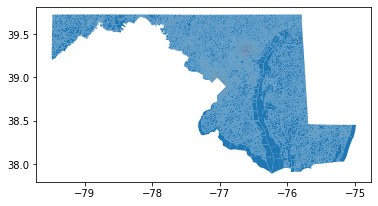

In [ ]:
# ALTERNATIVE
df = gpd.read_file(f'census block output/marylandRecomCB_{thread}_{round}.json')

df.plot()
# gdf = gpd.GeoDataFrame(censusBlocks['features'])
# print(gdf.head())

In [ ]:
#df2 = df.dissolve(by='CD116', aggfunc='sum')
df2.to_file(f'congressional district input/marylandPostprocessedCongressionalDistricts_{districting_plan_number}.json', driver='GeoJSON')

# Writing District Adjacencies for Border Census Blocks

In [ ]:
state_number = '24'
districting_plan_number = '01'

In [ ]:
districts = json.load(open(f'congressional district input/marylandPostprocessedCongressionalDistricts_{districting_plan_number}.json')) # write in the redistricting number
# censusBlocks = json.load(open(f'census block output/marylandRecomCB_{thread}_{round}.json')) # THIS SHOULD BE marylandRecomCB_18_0

In [ ]:
def returnFeature(cB):
    return Feature(geometry={'coordinates': cB['geometry']['coordinates'], 'type': 'Polygon'})
    
for cB in censusBlocks['features']:
  cB['properties']['FEATURE'] = returnFeature(cB)

for district in districts['features']:
  district['properties']['FEATURE'] = returnFeature(district)

In [ ]:
# Census Block Adjacency
for cB in censusBlocks['features']:
  for district in districts['features']:
    if cB['properties']['CD116'] != district['properties']['CD116']:
      if len(cB['geometry']['coordinates'][0]) >= 3 and len(district['geometry']['coordinates'][0]) >= 3:
        it = intersect([cB['properties']['FEATURE'], district['properties']['FEATURE']])
        if it:
          boundaryLen = length(it, units="ft")
          if boundaryLen >= 10:
            cB['properties']['ADJACENT_CD'] = district['properties']['CD116']
            break

In [ ]:
# deleting FEATURE property to reduce bloat
for cB in censusBlocks['features']:
  del cB['properties']['FEATURE']

for district in districts['features']:
  del district['properties']['FEATURE']

SQL CODE

In [ ]:
mydb = mysql.connector.connect(
  host='mysql3.cs.stonybrook.edu',
  user='MothBalls',
  password='changeit',
  database='MothBalls'
)
mycursor = mydb.cursor()

In [ ]:
population_sql = "INSERT INTO population (\
geoid20, \
cvap_american_indian_population, \
cvap_asian_population, \
cvap_black_population, \
cvap_hawaiian_population, \
cvap_hispanic_population, \
cvap_other_population, \
cvap_total_population, \
cvap_white_population, \
democrat_voters, \
other_voters, \
republican_voters, \
total_american_indian_population, \
total_asian_population, \
total_black_population, \
total_hawaiian_population, \
total_hispanic_population, \
total_other_population, \
total_total_population, \
total_white_population, \
vap_american_indian_population, \
vap_asian_population, \
vap_black_population, \
vap_hawaiian_population, \
vap_hispanic_population, \
vap_other_population, \
vap_total_population, \
vap_white_population\
) VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)"

censusblock_sql = "INSERT INTO census_block (\
geoid20, \
adjacent_congressional_district, \
congressional_district, \
congressional_districtid, \
districting_plan, \
precinctid, \
state, \
geometry_type, \
geometry \
) VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s)"

district_sql = "INSERT INTO district (\
geoid20, \
congressional_district, \
districting_plan, \
state \
) VALUES (%s,%s,%s,%s)"

districting_plan_sql = "INSERT INTO districting_plan (\
id, \
districting_plan, \
state \
) VALUES (%s,%s,%s)"


INSERT INTO DISTRICTING_PLAN TABLE

In [ ]:
val = ((districting_plan_number + state_number), \
         districting_plan_number, \
         state_number \
)
mycursor.execute(districting_plan_sql, val)
mydb.commit()

INSERT INTO DISTRICT TABLE

In [ ]:
for feature in districts['features']:
  properties = feature['properties']
  val = ((districting_plan_number + state_number + properties['CD116']), \
         properties['CVAP_AMERICANINDIAN'], \
         properties['CVAP_ASIAN'], \
         properties['CVAP_BLACK'], \
         properties['CVAP_HAIWAIIAN'], \
         properties['CVAP_HISPANIC'], \
         properties['CVAP_OTHER'], \
         properties['CVAP_TOTAL'], \
         properties['CVAP_WHITE'], \
         properties['DEMOCRAT'], \
         properties['OTHER'], \
         properties['REPUBLICAN'], \
         properties['TOTAL_AMERICANINDIAN'], \
         properties['TOTAL_ASIAN'], \
         properties['TOTAL_BLACK'], \
         properties['TOTAL_HAWAIIAN'], \
         properties['TOTAL_HISPANIC'], \
         properties['TOTAL_OTHER'], \
         properties['TOTAL_TOTAL'], \
         properties['TOTAL_WHITE'], \
         properties['VAP_AMERICANINDIAN'], \
         properties['VAP_ASIAN'], \
         properties['VAP_BLACK'], \
         properties['VAP_HAWAIIAN'], \
         properties['VAP_HISPANIC'], \
         properties['VAP_OTHER'], \
         properties['VAP_TOTAL'], \
         properties['VAP_WHITE'] \
  )
  mycursor.execute(population_sql, val)
  mydb.commit()

  val = ((districting_plan_number + state_number + properties['CD116']), \
         properties['CD116'], \
         districting_plan_number, \
         state_number \
  )
  mycursor.execute(district_sql, val)
  mydb.commit()

INPUT DATA INTO POPULATION TABLE AND CENSUS BLOCK TABLE FOR ALL CENSUS BLOCKS

In [ ]:
iter = 0
for feature in censusBlocks['features']:
  iter += 1
  if iter >= 1000:
    break
  properties = feature['properties']
  val = ((districting_plan_number + properties['GEOID20']), \
         properties['CVAP_AMERICANINDIAN'], \
         properties['CVAP_ASIAN'], \
         properties['CVAP_BLACK'], \
         properties['CVAP_HAIWAIIAN'], \
         properties['CVAP_HISPANIC'], \
         properties['CVAP_OTHER'], \
         properties['CVAP_TOTAL'], \
         properties['CVAP_WHITE'], \
         properties['DEMOCRAT'], \
         properties['OTHER'], \
         properties['REPUBLICAN'], \
         properties['TOTAL_AMERICANINDIAN'], \
         properties['TOTAL_ASIAN'], \
         properties['TOTAL_BLACK'], \
         properties['TOTAL_HAWAIIAN'], \
         properties['TOTAL_HISPANIC'], \
         properties['TOTAL_OTHER'], \
         properties['TOTAL_TOTAL'], \
         properties['TOTAL_WHITE'], \
         properties['VAP_AMERICANINDIAN'], \
         properties['VAP_ASIAN'], \
         properties['VAP_BLACK'], \
         properties['VAP_HAWAIIAN'], \
         properties['VAP_HISPANIC'], \
         properties['VAP_OTHER'], \
         properties['VAP_TOTAL'], \
         properties['VAP_WHITE'] \
  )
  mycursor.execute(population_sql, val)
  # mydb.commit()

  if 'ADJACENT_CD' in properties:
    val = ((districting_plan_number + properties['GEOID20']), \
         properties['ADJACENT_CD'], \
         properties['CD116'], \
         (districting_plan_number + properties['STATE'] + properties['CD116']), \
         districting_plan_number, \
         properties['PRECINCTID'], \
         properties['STATE'], \
         feature['geometry']['type'], \
         json.dumps(feature['geometry']['coordinates']), \
   )
  else:
    val = ((districting_plan_number + properties['GEOID20']), \
         None, \
         properties['CD116'], \
         (districting_plan_number + properties['STATE'] + properties['CD116']), \
         districting_plan_number, \
         properties['PRECINCTID'], \
         properties['STATE'], \
         feature['geometry']['type'], \
         json.dumps(feature['geometry']['coordinates']), \
   )

  mycursor.execute(censusblock_sql, val)
  # mydb.commit()
mydb.commit()

INPUT DATA INTO DISTRICTING PLAN STATISTICS TABLE

In [ ]:
districting_plan_statistics_sql = "INSERT INTO districting_plan_statistics (\
id, \
redistrict_number, \
state, \
total_population_score, \
vap_population_score, \
cvap_population_score, \
efficiency_gap, \
num_congressional_districts, \
num_democratic_congressional_districts, \
num_republican_congressional_districts \
) VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)"

recomStatistics = json.load(open(f'recom_statistics_{thread}_{round}.json'))

#MAKE SURE TO CHANGE NUMBERS FOR UTAH
val = ((districting_plan_number + state_number), \
         districting_plan_number, \
         state_number, \
         remoStatistics['total_pop_score_diff'], \
         remoStatistics['vap_pop_score_diff'], \
         remoStatistics['cvap_pop_score_diff'], \
         remoStatistics['eg'], \
         8, \
         7, \
         1 \
)
mycursor.execute(districting_plan_statistics_sql, val)
mydb.commit()

In [ ]:
sql2 = 'DELETE FROM population WHERE cvap_hispanic_population<1000000'
mycursor.execute(sql2)
mydb.commit()

sql2 = 'DELETE FROM census_block WHERE state=24'
mycursor.execute(sql2)
mydb.commit()

sql2 = 'DELETE FROM district WHERE state=24'
mycursor.execute(sql2)
mydb.commit()

DatabaseError: ignored